<a href="https://colab.research.google.com/github/PGCodehub/Deeplearning/blob/master/Image_Classifier_pytorch_transferL/Image_Classifier_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision

In [23]:
%cd /content/
!if ! test -d aipnd-project/; then git clone https://github.com/udacity/aipnd-project.git ; fi  
%cd aipnd-project/
!mkdir -p flowers/
%cd flowers/
!wget -nc https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz
!if ! test -d test/; then tar -xzf flower_data.tar.gz; fi  
!ls -l
%cd /content/aipnd-project/
!ls -l

/content
Cloning into 'aipnd-project'...
remote: Enumerating objects: 29, done.
remote: Total 29 (delta 0), reused 0 (delta 0), pack-reused 29
Unpacking objects: 100% (29/29), done.
/content/aipnd-project
/content/aipnd-project/flowers
--2018-11-16 10:10:11--  https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.105.133
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.105.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344873452 (329M) [application/x-gzip]
Saving to: ‘flower_data.tar.gz’

flower_data.tar.gz  100%[===================>] 328.90M  36.4MB/s    in 10s     

2018-11-16 10:10:22 (32.6 MB/s) - ‘flower_data.tar.gz’ saved [344873452/344873452]

total 336808
-rw-r--r--   1 root root 344873452 Jan 26  2018 flower_data.tar.gz
drwxrwxr-x 104 1000 1000      4096 Jan 15  2018 test
drwxrwxr-x 104 1000 1000      4096 Jan 15  2018 train
drwxrwxr-x 104 1000 1000      4096 Jan

In [72]:


%cd /content/aipnd-project/
!ls -l
%cd /content/
!ls -l

/content/aipnd-project
total 40
drwxr-xr-x 2 root root  4096 Nov 16 10:10  assets
-rw-r--r-- 1 root root  2218 Nov 16 10:10  cat_to_name.json
drwxr-xr-x 5 root root  4096 Nov 16 10:10  flowers
-rw-r--r-- 1 root root 17153 Nov 16 10:10 'Image Classifier Project.ipynb'
-rw-r--r-- 1 root root  1064 Nov 16 10:10  LICENSE
-rw-r--r-- 1 root root     0 Nov 16 10:10  predict.py
-rw-r--r-- 1 root root   250 Nov 16 10:10  README.md
-rw-r--r-- 1 root root     0 Nov 16 10:10  train.py
/content
total 196512
drwxr-xr-x 5 root root      4096 Nov 16 10:10 aipnd-project
-rw-r--r-- 1 root root 201216256 Nov 16 11:16 checkpointresnet.pth
drwxr-xr-x 2 root root      4096 Nov 15 01:02 sample_data


# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [0]:
# Imports here
import torch 
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from PIL import Image

import json


#for keeping workspace live during non activity
#from workspace_utils import active_session

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [0]:
data_dir = '/content/aipnd-project/flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [0]:
# TODO: Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])]) 

'''valid_transforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])'''

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
train_datasets = datasets.ImageFolder(train_dir,train_transforms)
valid_datasets = datasets.ImageFolder(valid_dir,test_transforms)
test_datasets = datasets.ImageFolder(test_dir,test_transforms)



# TODO: Using the image datasets and the trainforms, define the dataloaders
train_dataloaders = torch.utils.data.DataLoader(train_datasets, batch_size=64, shuffle= True )
valid_dataloaders = torch.utils.data.DataLoader(valid_datasets, batch_size=64, shuffle= True )
test_dataloaders = torch.utils.data.DataLoader(test_datasets, batch_size=32 )

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [0]:
with open('/content/aipnd-project/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [0]:
# TODO: Build and train your network

In [6]:
# download models
#vgg_model = models.vgg16(pretrained = True)
rsnet_model = models.resnet50(pretrained = True)
rsnet_model

# incep = models.inception_v3(pretrained = True)
# incep

# de = models.densenet121(pretrained= True)
# de
# rsnet_model
# try:
#     print(rsnet_model.classifier.in_features)
# except AttributeError:
#     print(rsnet_model.fc.in_features)
    
# rsnet_model


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [0]:
#freezing parameters of model
for param in rsnet_model.parameters():
    param.requires_grad = False

In [0]:
#Defining Classifier with network class style
class Network(nn.Module):
    def __init__(self,input_size, hiddenlayers, output_size, drop_p = 0.5):
        
        super().__init__()
        
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hiddenlayers[0])])
        
        layersizes = zip(hiddenlayers[:-1],hiddenlayers[1:])
                
        #print(layersizes)
        
        self.hidden_layers.extend([nn.Linear(h1,h2) for h1,h2 in layersizes])
        
        self.output = nn.Linear(hiddenlayers[-1],output_size)
                
        self.dropout = nn.Dropout(p = drop_p)
        
    def forward(self , x):
        
        for lin in self.hidden_layers:
            x = F.relu(lin(x))
            x = self.dropout(x)
            
        x = self.output(x)
        
        return F.log_softmax(x, dim= 1)

In [0]:
#building network with sequential style
# Build a feed-forward network
classifier = nn.Sequential(nn.Linear(2048, 512),
                           nn.ReLU(),
                           nn.Dropout(p=0.5),
                           nn.Linear(512, 256),
                           nn.ReLU(),
                           nn.Dropout(p=0.5),
                           nn.Linear(256, 102),
                           nn.LogSoftmax(dim=1))


In [10]:
#set calssifer for model
fcclassifier = Network(2048,[512],102)

#vgg_model.classifier = classifier
rsnet_model.fc = fcclassifier
rsnet_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [0]:
#Set which device to run
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu" )

In [0]:
#Validation 
def Validation(model,criterion,valid_dataloaders):
    testloss = 0
    accuracy = 0
    totaldatasetlen = 0
    model.to(device)

    for images , labels in valid_dataloaders:
        images,labels = images.to(device),labels.to(device)
        output = model.forward(images)
        testloss += criterion(output, labels).item()
        
        ps = torch.exp(output)
        
        equity = (labels == ps.max(dim = 1)[1])
        totaldatasetlen +=labels.size(0)
        accuracy += equity.type(torch.FloatTensor).mean()
    
    
    return testloss,accuracy,totaldatasetlen

In [0]:
#train the network
def trainthemodel(model,optimizer,criterion,train_dataloaders,valid_dataloaders,epochs = 10,print_every = 40,):
    

    running_loss = 0 
    steps = 0
    
    model.to(device)

    print("The training about to start and print every {} steps...".format(printevery))
    print("The divice its running on is : {}. ..".format(device))


    for e in range(epochs):
        model.train()
        
        for images,labels in train_dataloaders:
            steps += 1
            images,labels = images.to(device),labels.to(device)
            optimizer.zero_grad()
            output = model.forward(images)
            Loss = criterion(output,labels)
            
            Loss.backward()
            optimizer.step()
            
            running_loss += Loss.item()
            
            
            if steps%printevery == 0:
                model.eval()
                with torch.no_grad():
                    test_loss,accuracy,totaldatalen = Validation(model,criterion,valid_dataloaders)
                
                print("The no of steps is {}...".format(steps),
                      "The epoch is {}/{}....".format(e+1 ,epochs),
                      "The Loss of model is {:.4f}...".format(running_loss/printevery),
                      "Test Loss: {:.3f}.. ".format(test_loss/len(valid_dataloaders)),
                      "Test Accuracy: {:.3f}%".format(accuracy/len(valid_dataloaders) * 100)
                 )
                
                running_loss = 0
                model.train()    
            
    print("Training Complete")

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [0]:
# TODO: Do validation on testsekt

def Acuuracyontestset(model,criterion,test_dataloaders):
    testloss = 0
    accuracy = 0
    totaldatasetlen = 0
    
    model.to(device)
    
    model.eval()
    for images , labels in test_dataloaders:
        images,labels = images.to(device),labels.to(device)
        output = model.forward(images)        
        ps = torch.exp(output)
        
        equity = (labels == ps.max(dim = 1)[1])
        totaldatasetlen +=labels.size(0)
        accuracy += equity.type(torch.FloatTensor).sum().item()
    
    
    return accuracy,totaldatasetlen

In [0]:
def Acurracy(model):
    print("Calculating Acuracy:")
    with torch.no_grad():
        accuracy,total = Acuuracyontestset(model,criterion,test_dataloaders)
    
    print('Accuracy of the network on the {} test images: {}%...'.format(total,(100 * accuracy / total)))
    
    return (100 * accuracy / total)

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [0]:
# TODO: Save the checkpoint 
def savecheckpoint(filename):
    modelcheckpoint = { 'input_size':2048,
                  'output_size':102,
                   'epochs': epochs,
                    'learningrate': learningrate,
                   'model' : models.resnet50(pretrained= True),
                   'classifier' : rsnet_model.fc,
                   'state_Dict': rsnet_model.state_dict(),
                   'class_to_idx': train_datasets.class_to_idx
                   }
#'optimizer_state_dict':optimizer.state_dict(),
    torch.save(modelcheckpoint, filename)
    print("The model is saved in {} file..".format(filename))

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [0]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def loadCheckpoint(filepath):
    
    if device == 'cuda:0':
        checkpoint = torch.load(filepath)
    else:
        checkpoint = torch.load(filepath, map_location=lambda storage, loc: storage)
    
    model = checkpoint['model']
    for param in model.parameters():
        param.requires_grad = False
    
    model.fc = checkpoint['classifier']
    model.load_state_dict(checkpoint['state_Dict'])
    #optimizer = checkpoint['optimizer_state_dict']
    epochs = checkpoint['epochs']
    model.class_to_idx = checkpoint['class_to_idx']
    
    
    
    
        
        #model.to()
    return model
    print("The model is loaded from {} file..".format(filepath))

In [0]:
#All the hyper-parameters
printevery = 40
epochs = 10

#Use learning rate = 0.001 for normal upto 80% beyond 80 use 0.0005 or even lower like 0.0003
learningrate = 0.001

#Define optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(rsnet_model.fc.parameters(), lr = learningrate)

In [57]:
#Traning the model and Accuracy on test set
#with active_session():
#    trainthemodel(rsnet_model,optimizer,criterion,train_dataloaders,valid_dataloaders,epochs,printevery)
#    old_acuraccy = Acurracy(rsnet_model)
    
    
    
trainthemodel(rsnet_model,optimizer,criterion,train_dataloaders,valid_dataloaders,epochs,printevery)
old_acuraccy = Acurracy(rsnet_model)

The training about to start and print every 40 steps...
The divice its running on is : cuda:0. ..
The no of steps is 40... The epoch is 1/10.... The Loss of model is 4.3822... Test Loss: 3.851..  Test Accuracy: 12.649%
The no of steps is 80... The epoch is 1/10.... The Loss of model is 3.6956... Test Loss: 3.006..  Test Accuracy: 36.236%
The no of steps is 120... The epoch is 2/10.... The Loss of model is 3.1181... Test Loss: 2.316..  Test Accuracy: 46.774%
The no of steps is 160... The epoch is 2/10.... The Loss of model is 2.6423... Test Loss: 1.852..  Test Accuracy: 56.399%
The no of steps is 200... The epoch is 2/10.... The Loss of model is 2.3315... Test Loss: 1.500..  Test Accuracy: 66.615%
The no of steps is 240... The epoch is 3/10.... The Loss of model is 2.0884... Test Loss: 1.382..  Test Accuracy: 67.163%
The no of steps is 280... The epoch is 3/10.... The Loss of model is 1.9626... Test Loss: 1.267..  Test Accuracy: 70.014%
The no of steps is 320... The epoch is 4/10.... Th

In [58]:
#savingcheckpoint and load
#with active_session():
#   filename = 'checkpointresnet.pth'
#   savecheckpoint(filename)
#   rsnet_model = loadCheckpoint(filename) 
  
  
filename = 'checkpointresnet.pth'
savecheckpoint(filename)
rsnet_model = loadCheckpoint(filename)   

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Network. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


The model is saved in checkpointresnet.pth file..


In [59]:
#checking is model is saved and can load properly

print("Accuracy of newly loaded model :")

new_accuracy = Acurracy(rsnet_model)

if old_acuraccy == new_accuracy:
    print("Accuracy seems to match! Modelsaved and  loaded successfully!")
else:
    print("Loading Model Unsuccessfull :(")

Accuracy of the network on the 819 test images: 86.32478632478633%...
Accuracy seems to match! Modelsaved and  loaded successfully!


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # TODO: Process a PIL image for use in a PyTorch model
    
    imag = Image.open(image)
    
    imsize = imag.size
    
    #print(imsize)
    
    maxwidth = 256
    maxheight = 256
    
    #for keeping aspect ratio
    ratio = max(maxwidth/imsize[0],maxheight/imsize[1])
    
    resize_values = (int(imsize[0]*ratio),int(imsize[1]*ratio))
    
    imag = imag.resize(resize_values,Image.ANTIALIAS)
    
    #print(imag.size)
    
    def centercrop(im,neww,newh):
        w,h = im.size
        
        left = (w-neww)/2
        right = (w+neww)/2
        
        top = (h-newh)/2
        bottom = (h+newh)/2
        
        im = im.crop((left,top,right,bottom))
        
        return im
    
    imag = centercrop(imag,224,224)
    
    #print(imag.size)

    
    np_image = np.array(imag)
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    np_image = np_image / 255
    
    np_image = np_image-mean
    
    np_image = np_image/std
    
    #print(np_image.shape)
    
    np_image = np_image.transpose((2,0,1))
    
    #print(np_image.shape)

    
    torch_image = torch.from_numpy(np_image)
    
    return torch_image
    

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [0]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy()
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image =  (image*std) + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

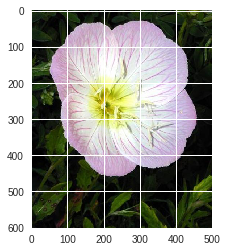

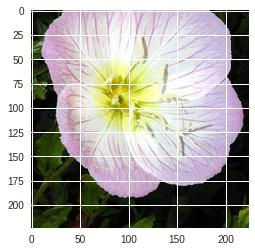

In [63]:
#Check if image is properly preprocessed
path = test_dir + '/1/image_06743.jpg'

image = Image.open(path)
fig, ax = plt.subplots()
image = np.array(image)

ax.imshow(image)

#image = np.clip(image, 0, 1)
#ax.axis('off')

imshow(process_image(path))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    
    image = process_image(image_path)
    
    #print(image.shape)

    image.unsqueeze_(0)
    
    #print(image.shape)
    
    image = image

    image = image.to(device)
    
    model.type(torch.DoubleTensor)
    
    model.to(device)
    
    model.eval()
    
    with torch.no_grad():
        
        output = model.forward(image)
        
        prob = torch.exp(output)
        
        probs , indices = torch.topk(prob , topk) 
        
                
        indice = indices.cpu()
        
        indice = indice.numpy()[0]
        
        # Convert indices to classes
        idx_to_class = {val: key for key, val in model.class_to_idx.items()}  
        
        #print(idx_to_class)
        
        classes = [idx_to_class[index] for index in indice]
        
    
    return  probs , classes
        

In [0]:
#For prediction of topk Classes
path = test_dir + '/100/image_07899.jpg'

probs, classes = predict(path, rsnet_model)

print(probs)
print(classes)

#print(usemodel.class_to_idx)

tensor([[ 0.7458,  0.1210,  0.0891,  0.0167,  0.0157]], dtype=torch.float64)
['100', '41', '71', '5', '17']


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [0]:
# TODO: Display an image along with the top 5 classes

In [0]:
def SanityCheck(path):
    
    image = Image.open(path)
    
    lis = path.split("/")
    
    OriginalClass = cat_to_name[lis[-2]]
    
    probs, classes = predict(path, rsnet_model)
    
    probs = probs.cpu()
    probs = probs.numpy()
    
    TopKClasses = [cat_to_name[clas] for clas in classes]
    
    
    plt.figure(figsize = [5, 10]) # larger figure size for subplots
    
    #Original Image
    ax = plt.subplot(2,1,1)
    
    image = np.array(image)
    
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(OriginalClass)
    
    #Image Prediction
    ax = plt.subplot(2,1,2)
    
    y_pos = np.arange(len(TopKClasses))
    
    ax.barh(y_pos, probs[0])
    ax.set_yticks(y_pos)
    ax.set_yticklabels(TopKClasses)
    ax.invert_yaxis() 
    ax.set_xlabel('Probability')
   

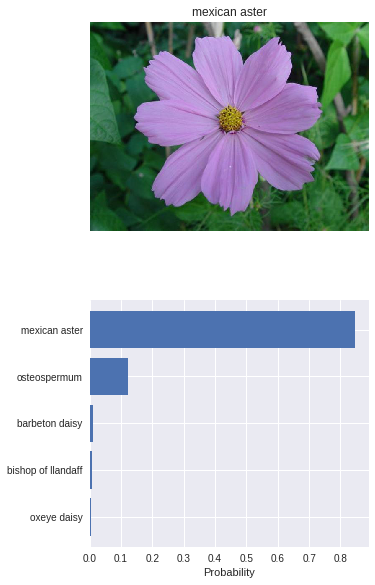

In [70]:
path = test_dir + '/34/image_06941.jpg'

#path = 'flowers/test/34/image_06941.jpg'


SanityCheck(path)